#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [ ]:
print('<oil_price>')
display(oil_price.head())

print('\n<orders>')
display(orders.head())

print('\n<sales>')
display(sales.head())

print('\n<products>')
display(products.head())

print('\n<stores>')
display(stores.head())

<oil_price>


,Date,WTI_Price,7DayMovingAvg
0,2014-01-01,NaN,NaN
1,2014-01-02,95.14,NaN
2,2014-01-03,93.66,NaN
3,2014-01-06,93.12,NaN
4,2014-01-07,93.31,NaN



<orders>


,Date,Store_ID,CustomerCount,Weekday
0,2014-01-01,25,840,2
1,2014-01-01,36,487,2
2,2014-01-02,1,1875,3
3,2014-01-02,2,2122,3
4,2014-01-02,3,3350,3



<sales>


,Date,Store_ID,Qty,Product_ID,DayOfWeek,Year,Month,Season
0,2014-01-01,1,0.0,3,2,2014,1,1
1,2014-01-01,1,0.0,5,2,2014,1,1
2,2014-01-01,1,0.0,7,2,2014,1,1
3,2014-01-01,1,0.0,8,2,2014,1,1
4,2014-01-01,1,0.0,10,2,2014,1,1



<products>


,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34



<stores>


,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


In [ ]:
display(oil_price.info())
print()
display(orders.info())
print()
display(sales.info())
print()
display(products.info())
print()
display(stores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           825 non-null    datetime64[ns]
 1   WTI_Price      795 non-null    float64       
 2   7DayMovingAvg  621 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.5 KB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57558 entries, 0 to 57557
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           57558 non-null  datetime64[ns]
 1   Store_ID       57558 non-null  int64         
 2   CustomerCount  57558 non-null  int64         
 3   Weekday        57558 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 1.5 MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934275 entries, 0 to 934274
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        934275 non-null  datetime64[ns]
 1   Store_ID    934275 non-null  int64         
 2   Qty         934275 non-null  float64       
 3   Product_ID  934275 non-null  int64         
 4   DayOfWeek   934275 non-null  int32         
 5   Year        934275 non-null  int32         
 6   Month       934275 non-null  int32         
 7   Season      934275 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(2)
memory usage: 42.8 MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product_ID    16 non-null     int64 
 1   Product_Code  16 non-null     object
 2   SubCategory   16 non-null     object
 3   Category      16 non-null     object
 4   LeadTime      16 non-null     int64 
 5   Price         16 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 896.0+ bytes


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Store_ID    54 non-null     int64 
 1   City        54 non-null     object
 2   State       54 non-null     object
 3   Store_Type  54 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


None

# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
df = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 3)]
df.head()

,Date,Store_ID,Qty,Product_ID,DayOfWeek,Year,Month,Season
645,2014-01-01,44,0.0,3,2,2014,1,1
1456,2014-01-02,44,9853.0,3,3,2014,1,1
2267,2014-01-03,44,8647.0,3,4,2014,1,1
3078,2014-01-04,44,15153.0,3,5,2014,1,1
3889,2014-01-05,44,15606.0,3,6,2014,1,1


In [ ]:
df.Date.min(), df.Date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-02-28 00:00:00'))

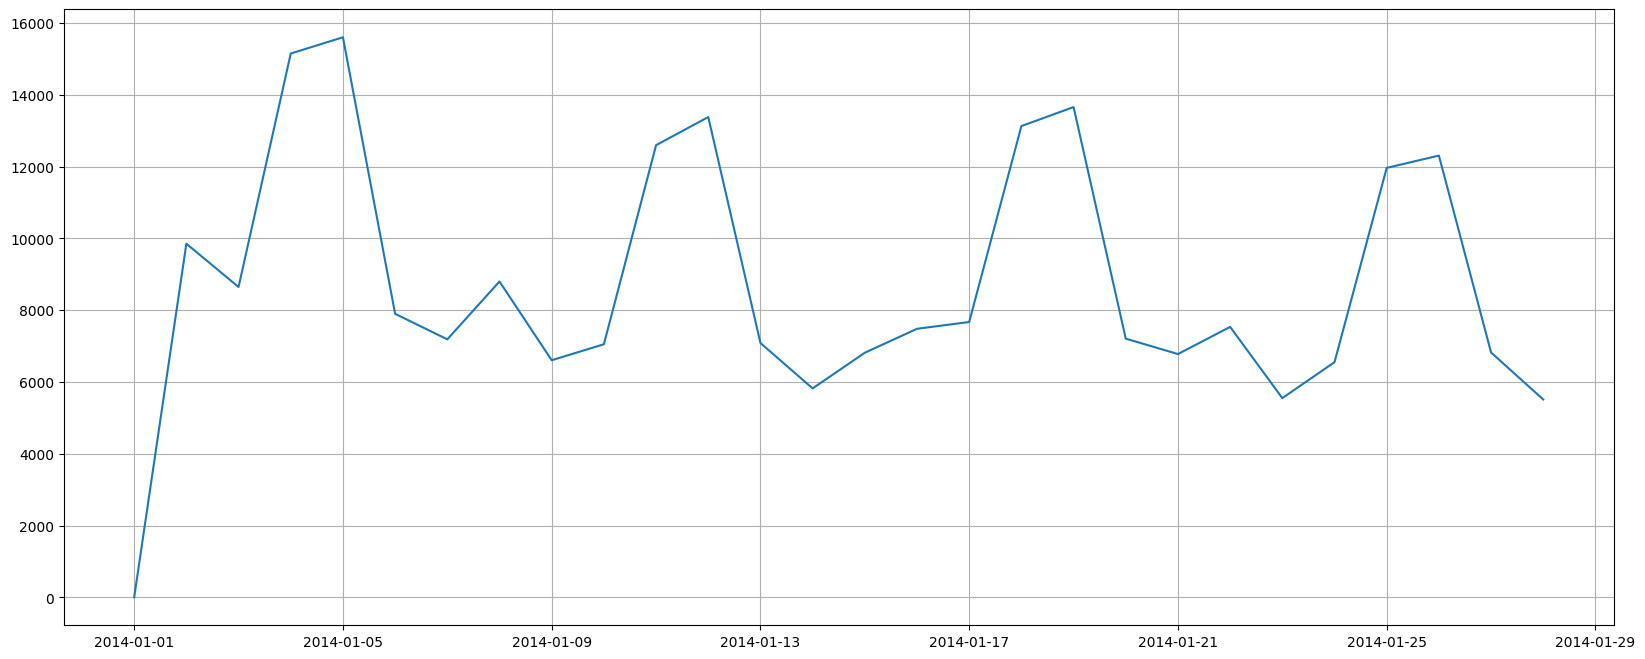

In [ ]:
# 3번 상품 판매량 추이(4주간)
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df[:28])
plt.grid()
plt.show()

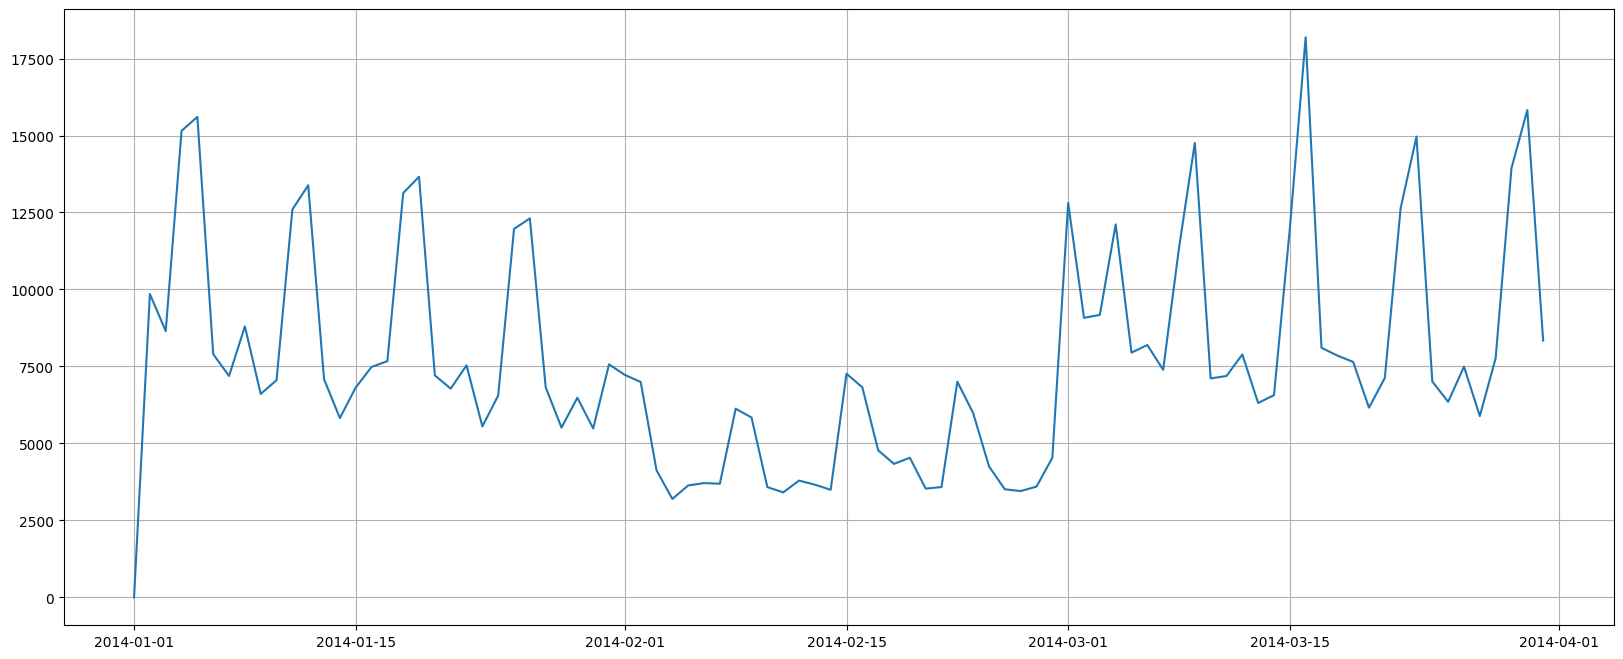

In [ ]:
# 3번 상품 판매량 추이(3개월간)
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df[:90])
plt.grid()
plt.show()

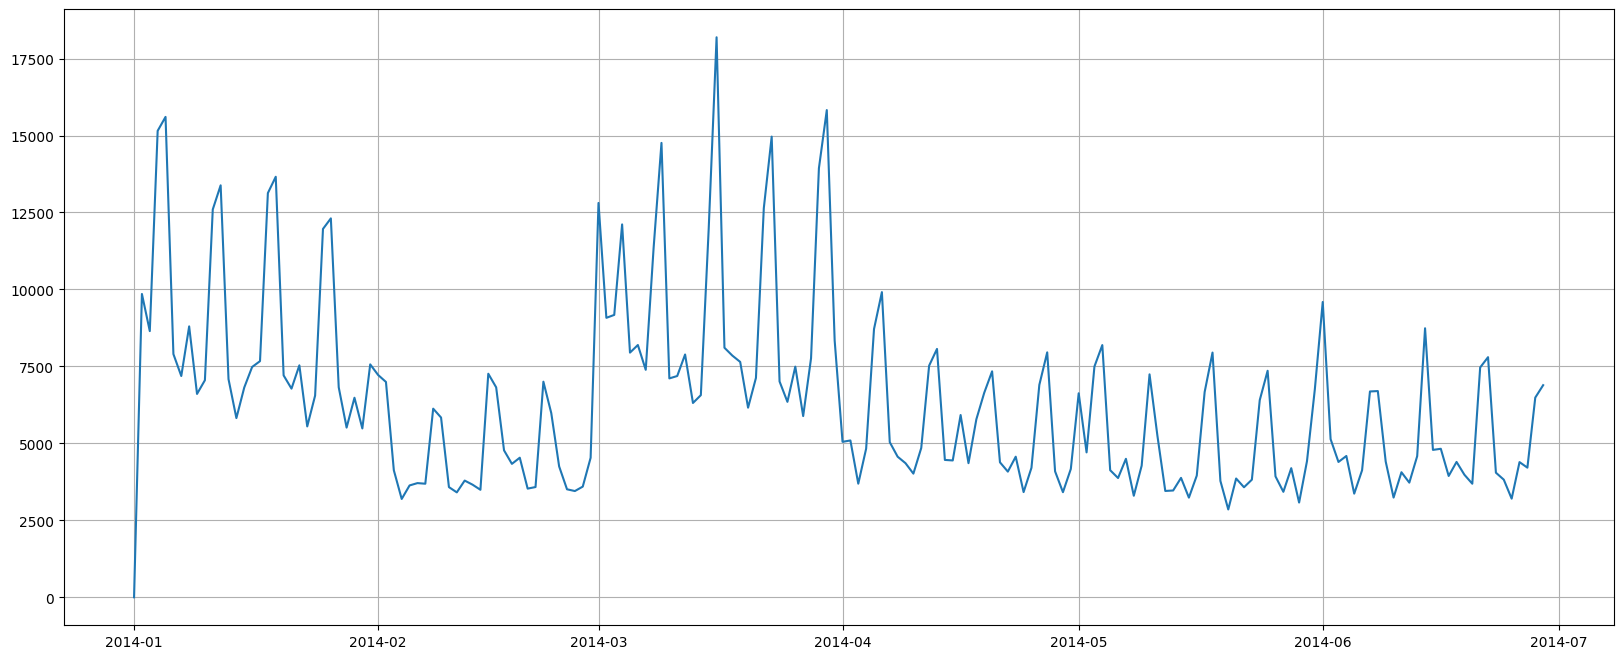

In [ ]:
# 3번 상품 판매량 추이(6개월간)
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df[:180])
plt.grid()
plt.show()

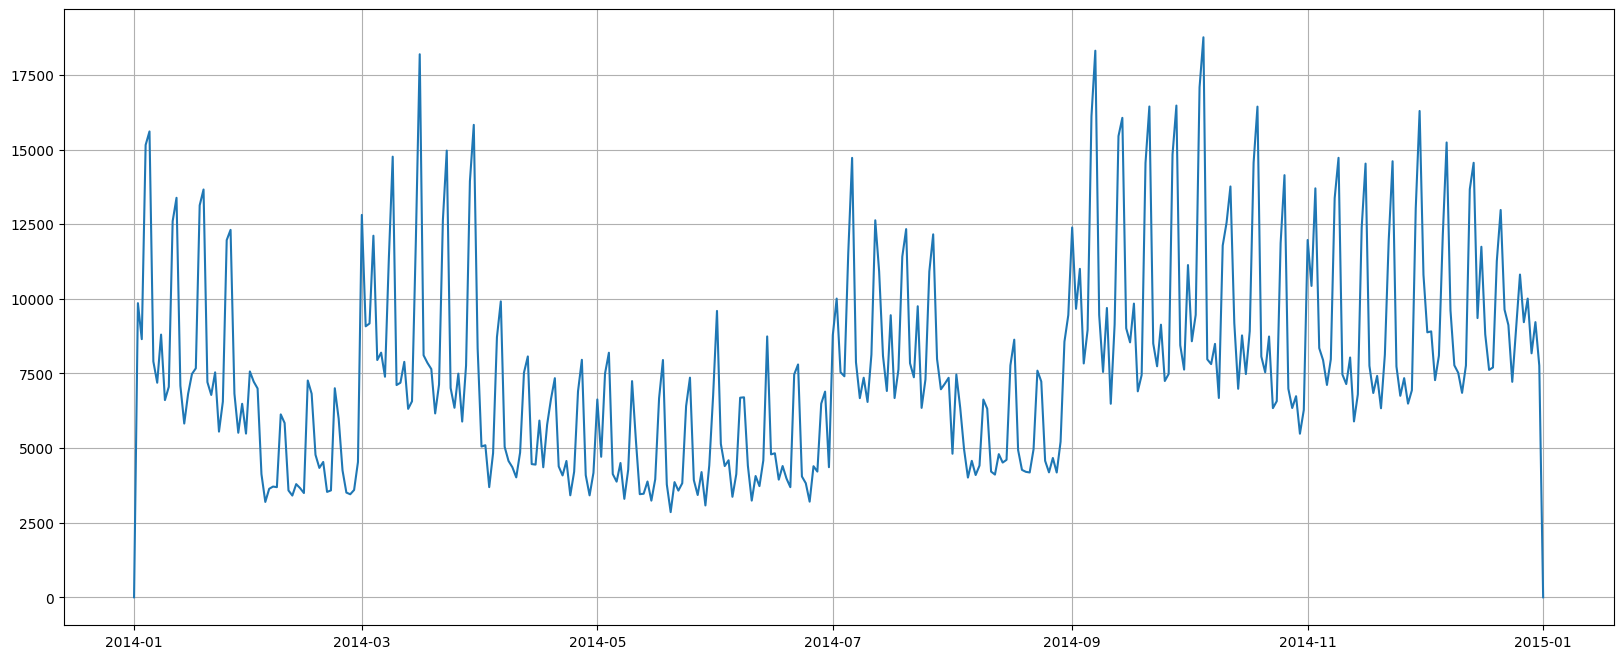

In [ ]:
# 3번 상품 판매량 추이(1년간)
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df[:365])
plt.grid()
plt.show()

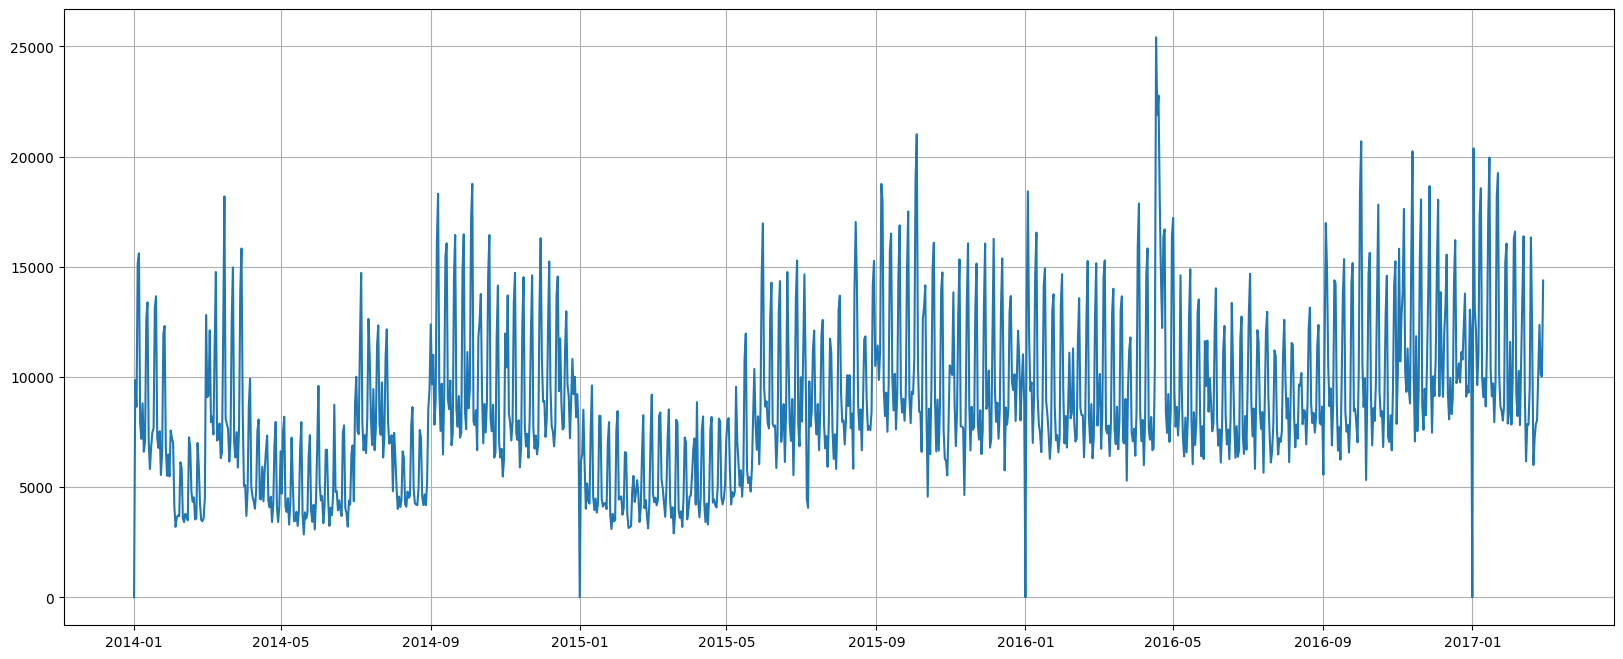

In [ ]:
# 대상 매장(44)와 대상 상품의 판매량 추이 그래프
# 12번 상품 판매량 추이(전체 기간)

plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df)
plt.grid()
plt.show()

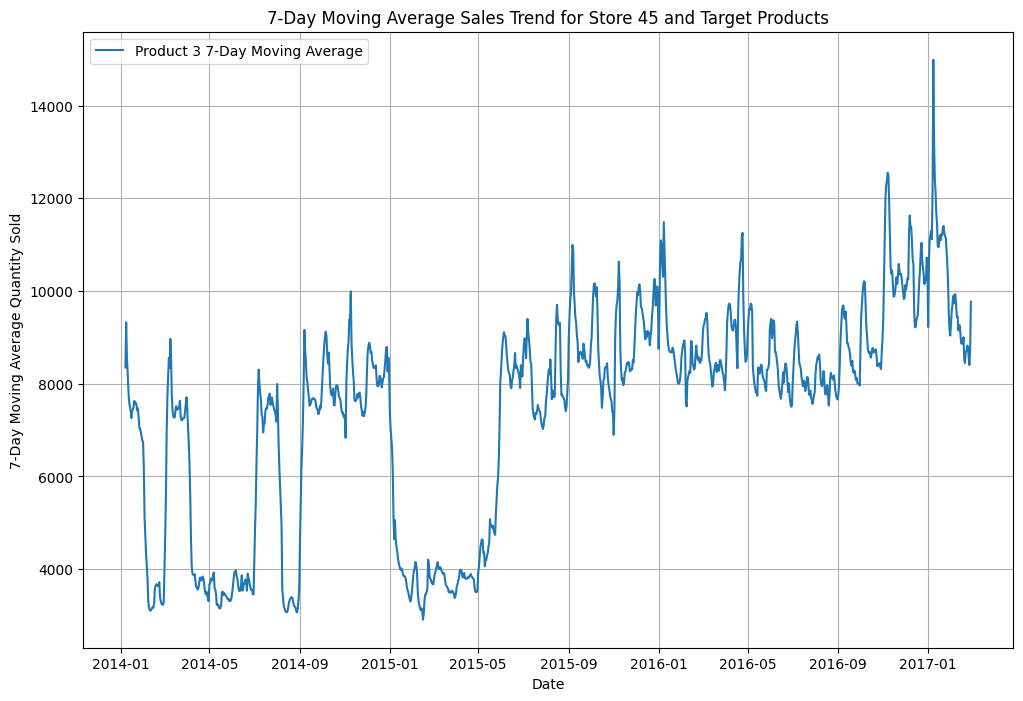

In [ ]:
import pandas as pd

# 대상 매장 및 대상 상품
target_store = 45
target_products = [3]

plt.figure(figsize=(12, 8))

for product_code in target_products:
    product_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'] == product_code)]
    # 7일 이동평균 계산
    product_sales['7DayMovingAvg'] = product_sales['Qty'].rolling(window=7).mean()
    plt.plot(product_sales['Date'], product_sales['7DayMovingAvg'], label=f'Product {product_code} 7-Day Moving Average')

plt.title(f'7-Day Moving Average Sales Trend for Store {target_store} and Target Products')
plt.xlabel('Date')
plt.ylabel('7-Day Moving Average Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


- 2016년 중반에 가장 높은 봉우리가 있어 이 시기에 매출이 크게 증가했음을 알 수 있습니다.

1. 전체적으로는 2014년부터 2016년 후반까지 상향 추세를 보이며 점진적인 매출 증가세를 나타냅니다.
2. 매출 하락 시기의 계곡 깊이는 단기 변동성이 있기는 하지만 비교적 일정한 반면, 상승 시기의 봉우리 높이는 특히 후반부에 가면서 더 큰 변동성을 보입니다.

- 요약하면 이 이동평균 차트는 단기 변동성과 장기 성장 패턴이 함께 나타나는 제품 매출의 역동적인 모습을 보여주고 있습니다.



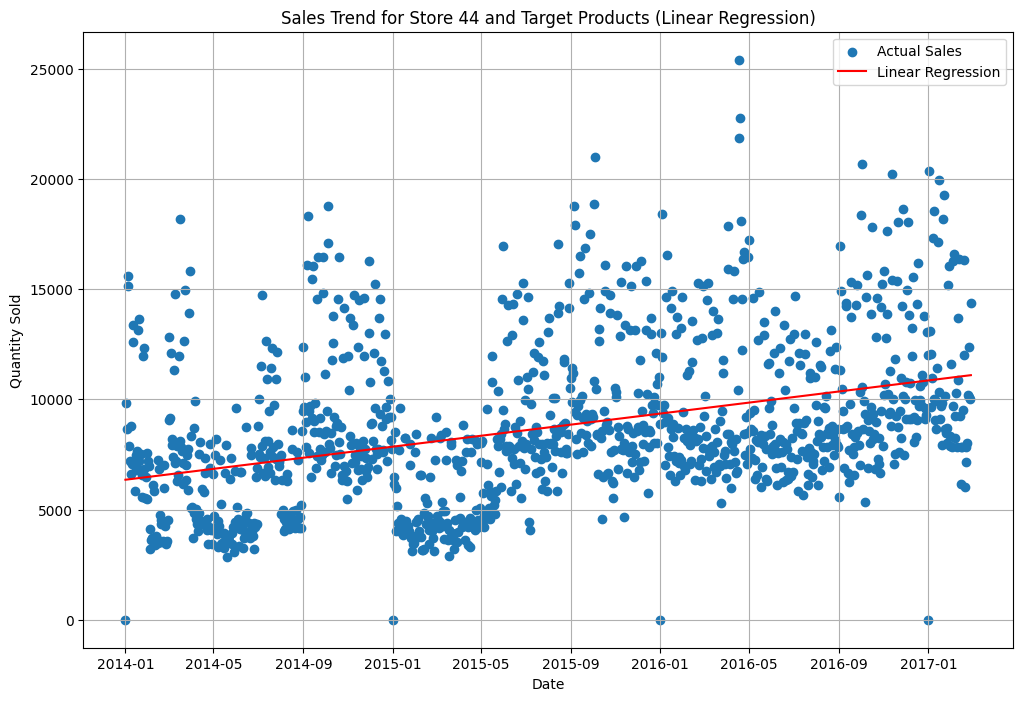

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 대상 매장 및 대상 상품
target_store = 44
target_products = [3]

# 대상 매장 및 대상 상품의 판매량 데이터 추출
store_product_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'].isin(target_products))]

# X와 y 데이터 준비
X = store_product_sales[['Date']].apply(lambda x: x.astype(np.int64) // 10**9)  # 날짜 데이터를 Unix 시간으로 변환
y = store_product_sales['Qty']

# 선형 회귀 모델 생성
model = LinearRegression()

# 모델 학습
model.fit(X, y)

# 모델 예측
y_pred = model.predict(X)

# 시각화
plt.figure(figsize=(12, 8))
plt.scatter(store_product_sales['Date'], y, label='Actual Sales')
plt.plot(store_product_sales['Date'], y_pred, color='red', label='Linear Regression')
plt.title(f'Sales Trend for Store {target_store} and Target Products (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [ ]:
df2 = pd.merge(sales, products)
df2 = df2[(df2['Store_ID'] == 44) & (df2['Category'] == 'Drink')]

In [ ]:
df2['Product_ID'].unique()

array([ 3, 38])

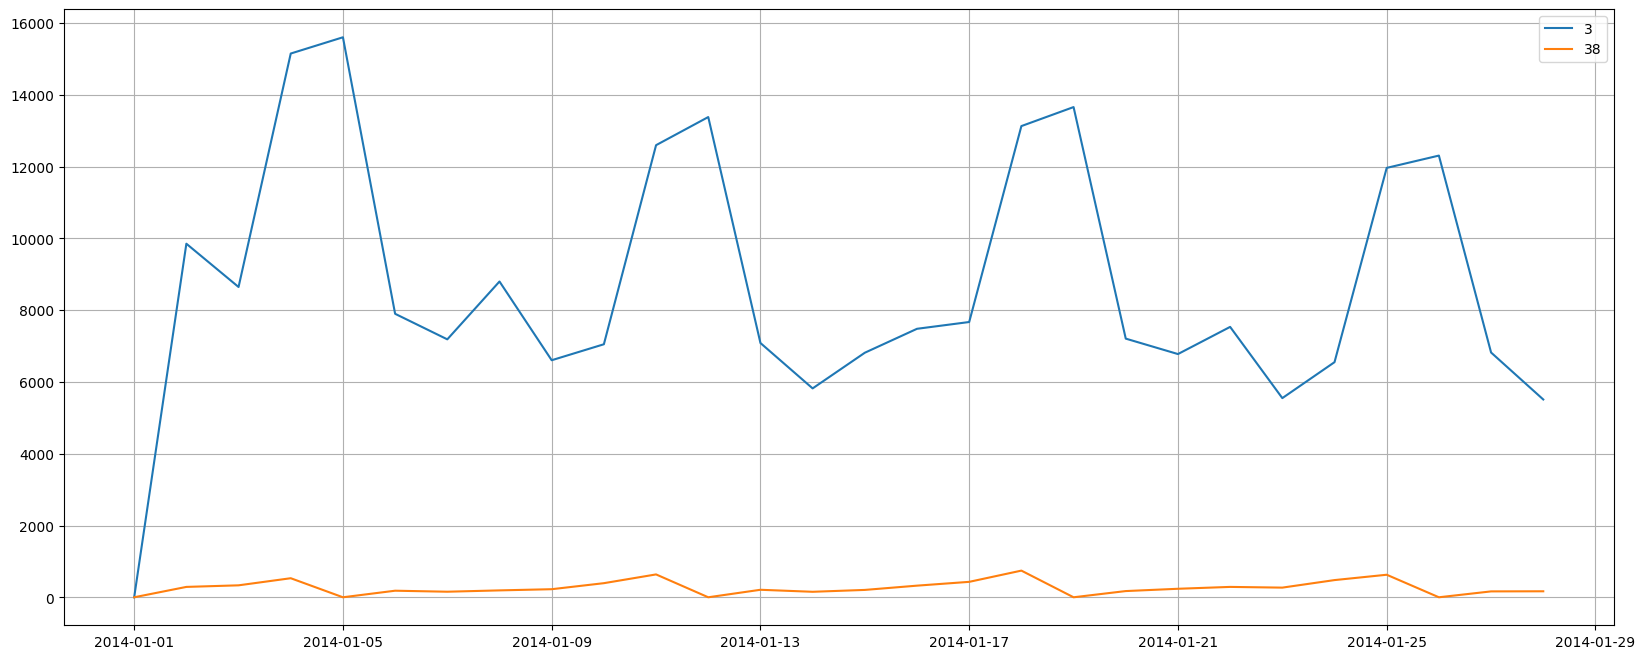

In [ ]:
# 상품별 데이터프레임 생성
df2_3 = df2[df2['Product_ID'] == 3]
df2_38 = df2[df2['Product_ID'] == 38]

# 12번과 같은 카테고리 상품별 판매량 추이(4주간)그래프
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df2_3[:28], label='3')
plt.plot('Date', 'Qty', data = df2_38[:28], label='38')

plt.grid()
plt.legend()
plt.show()

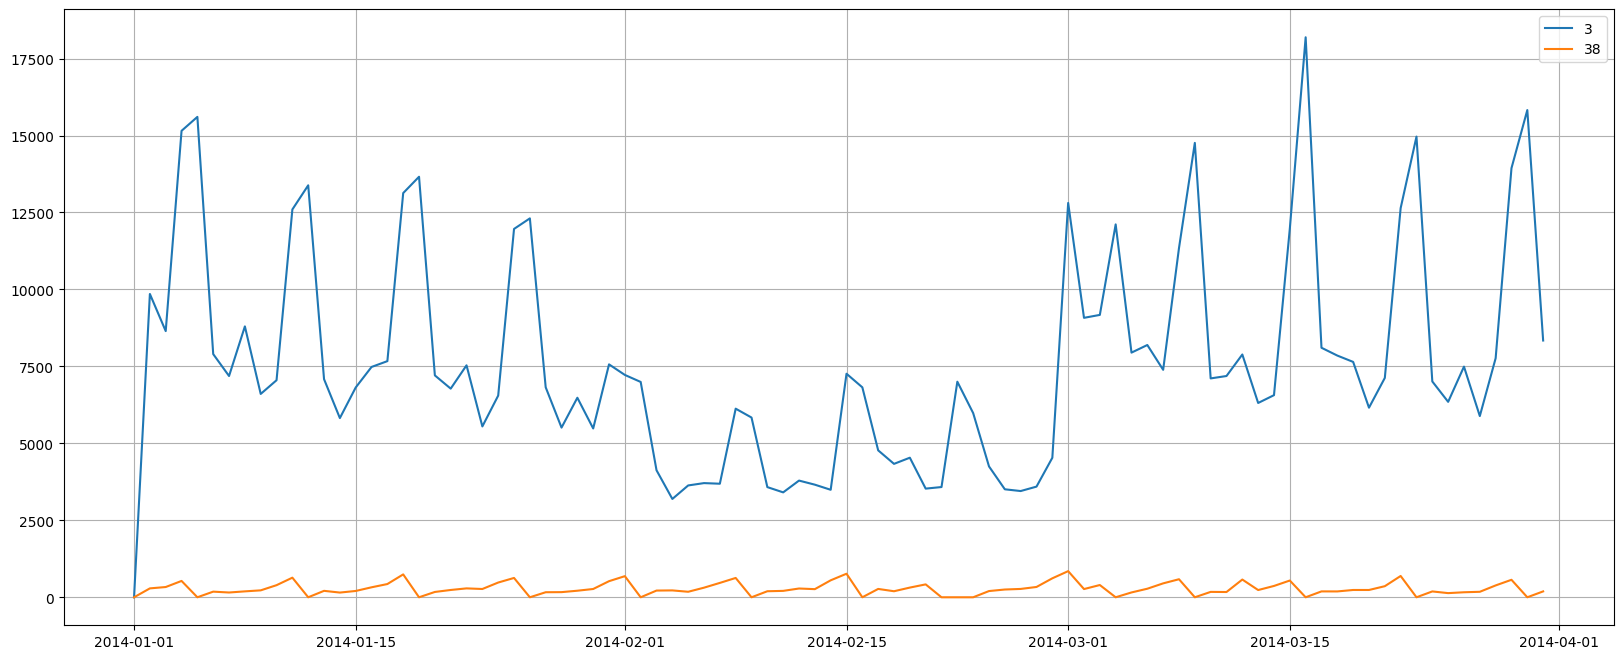

In [ ]:
# 12번과 같은 카테고리 상품별 판매량 추이(3개월)그래프
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df2_3[:90], label='3')
plt.plot('Date', 'Qty', data = df2_38[:90], label='38')

plt.grid()
plt.legend()
plt.show()

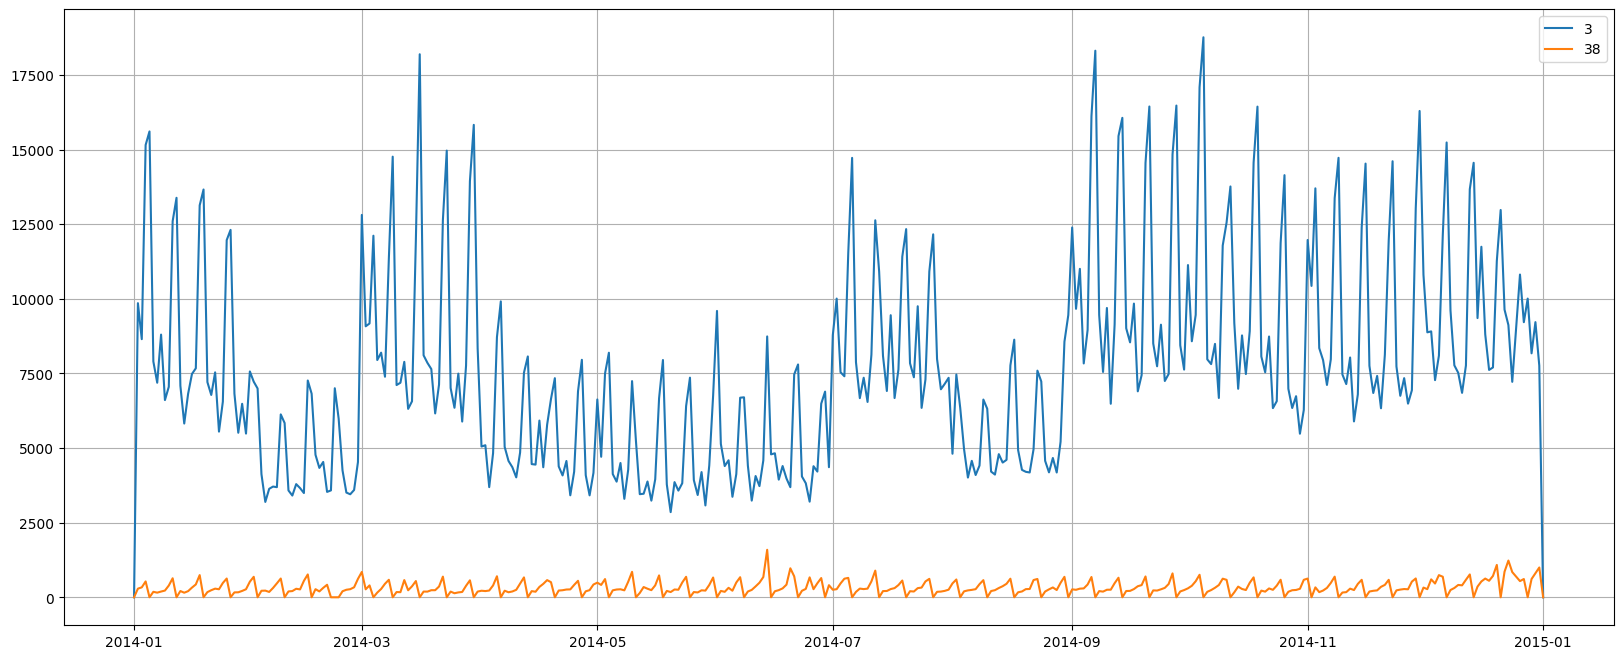

In [ ]:
# 12번과 같은 카테고리 상품별 판매량 추이(1년)그래프
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df2_3[:365], label='3')
plt.plot('Date', 'Qty', data = df2_38[:365], label='38')

plt.grid()
plt.legend()
plt.show()

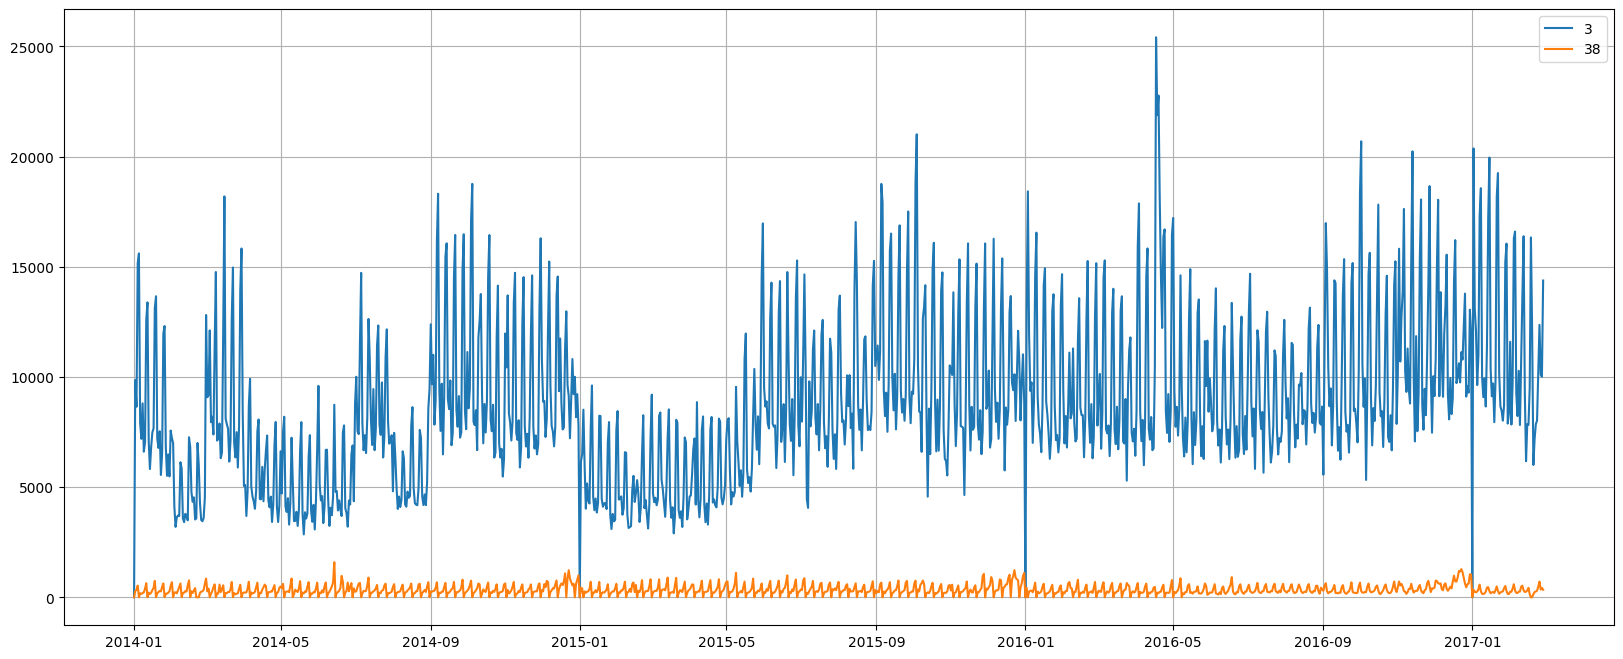

In [ ]:
# 12번과 같은 카테고리 상품별 판매량 추이(1년)그래프
plt.figure(figsize = (20,8))
plt.plot('Date', 'Qty', data = df2_3, label='3')
plt.plot('Date', 'Qty', data = df2_38, label='38')

plt.grid()
plt.legend()
plt.show()

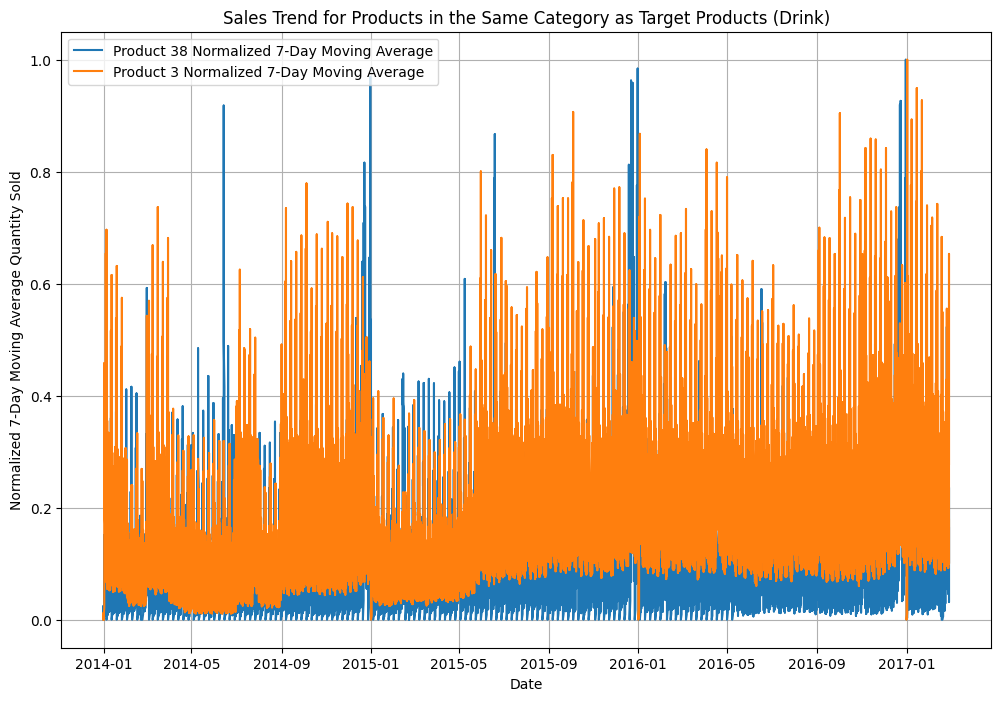

In [ ]:
# 대상 상품의 동일 카테고리의 상품별 판매량 추이 그래프
target_category = products[products['Product_ID'].isin(target_products)]['Category'].unique()[0]
similar_category_products = products[products['Category'] == target_category]['Product_ID'].unique()

plt.figure(figsize=(12, 8))

for product_code in similar_category_products:
    product_sales = sales[sales['Product_ID'] == product_code]
    # 7일 이동평균 계산
    product_sales['7DayMovingAvg'] = product_sales['Qty'].rolling(window=7).mean()
    # Min-Max 정규화 적용
    min_val = product_sales['7DayMovingAvg'].min()
    max_val = product_sales['7DayMovingAvg'].max()
    product_sales['Normalized'] = (product_sales['7DayMovingAvg'] - min_val) / (max_val - min_val)
    plt.plot(product_sales['Date'], product_sales['Normalized'], label=f'Product {product_code} Normalized 7-Day Moving Average')

plt.title(f'Sales Trend for Products in the Same Category as Target Products ({target_category})')
plt.xlabel('Date')
plt.ylabel('Normalized 7-Day Moving Average Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()

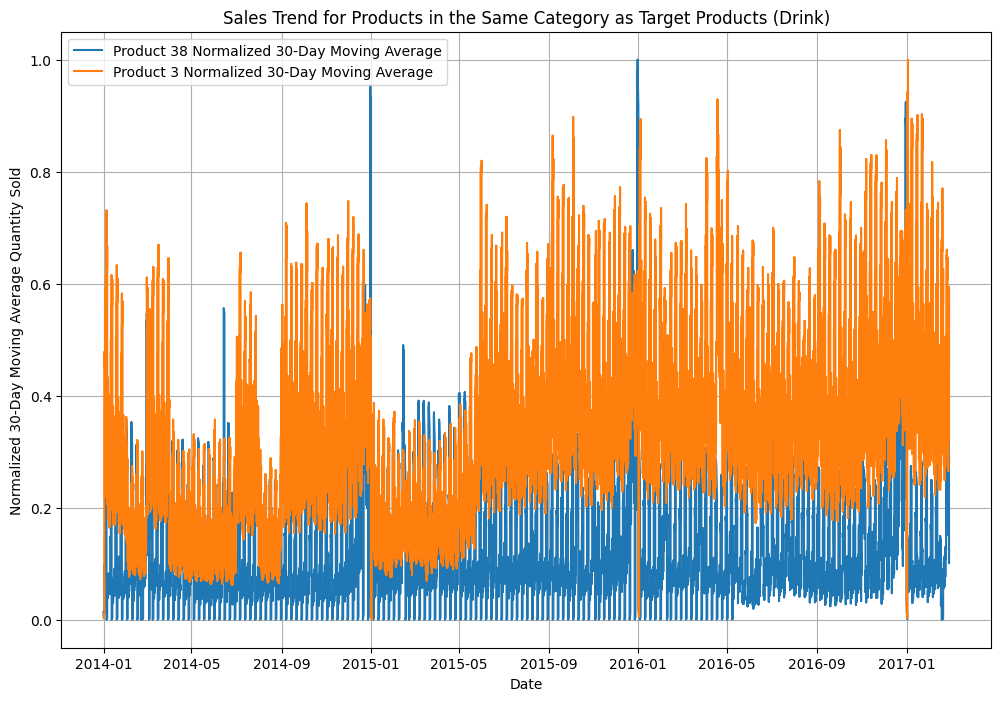

In [ ]:
# 대상 상품의 동일 카테고리의 상품별 판매량 추이 그래프
target_category = products[products['Product_ID'].isin(target_products)]['Category'].unique()[0]
similar_category_products = products[products['Category'] == target_category]['Product_ID'].unique()

plt.figure(figsize=(12, 8))

for product_code in similar_category_products:
    product_sales = sales[sales['Product_ID'] == product_code]
    # 30일 이동평균 계산
    product_sales['30DayMovingAvg'] = product_sales['Qty'].rolling(window=30).mean()
    # Min-Max 정규화 적용
    min_val = product_sales['30DayMovingAvg'].min()
    max_val = product_sales['30DayMovingAvg'].max()
    product_sales['Normalized'] = (product_sales['30DayMovingAvg'] - min_val) / (max_val - min_val)
    plt.plot(product_sales['Date'], product_sales['Normalized'], label=f'Product {product_code} Normalized 30-Day Moving Average')

plt.title(f'Sales Trend for Products in the Same Category as Target Products ({target_category})')
plt.xlabel('Date')
plt.ylabel('Normalized 30-Day Moving Average Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


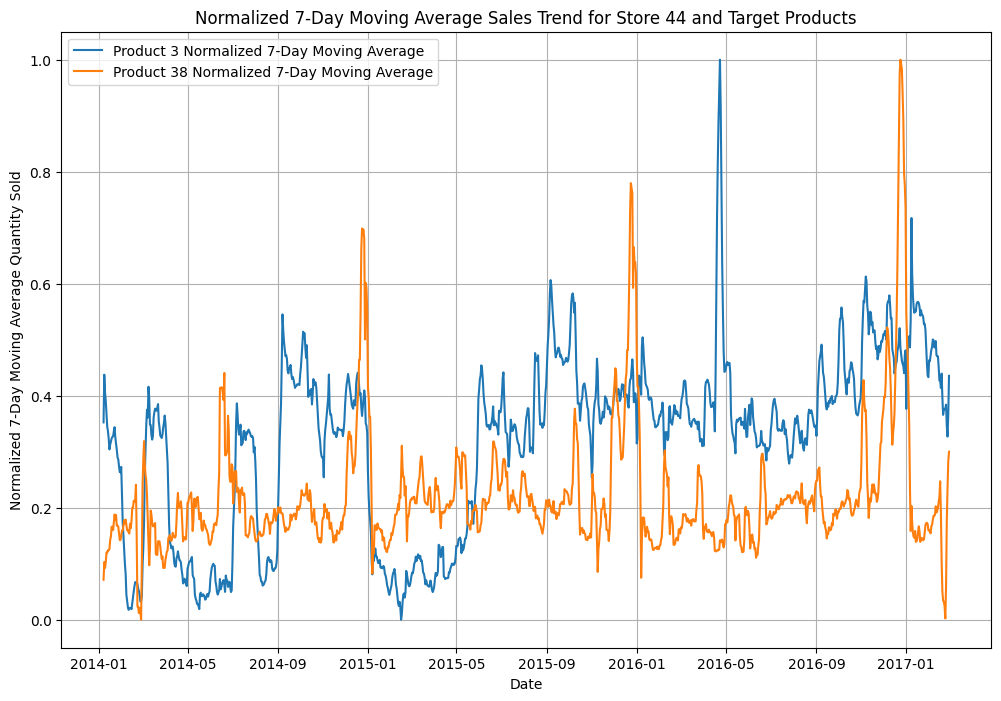

In [ ]:
import pandas as pd

# 대상 매장 및 대상 상품
target_store = 44
target_products = [3, 38]

plt.figure(figsize=(12, 8))

for product_code in target_products:
    product_sales = sales[(sales['Store_ID'] == target_store) & (sales['Product_ID'] == product_code)]
    # 7일 이동평균 계산
    product_sales['7DayMovingAvg'] = product_sales['Qty'].rolling(window=7).mean()
    # Min-Max 정규화 적용
    min_val = product_sales['7DayMovingAvg'].min()
    max_val = product_sales['7DayMovingAvg'].max()
    product_sales['Normalized'] = (product_sales['7DayMovingAvg'] - min_val) / (max_val - min_val)
    plt.plot(product_sales['Date'], product_sales['Normalized'], label=f'Product {product_code} Normalized 7-Day Moving Average')

plt.title(f'Normalized 7-Day Moving Average Sales Trend for Store {target_store} and Target Products')
plt.xlabel('Date')
plt.ylabel('Normalized 7-Day Moving Average Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


대상 상품의 동일 카테고리의 상품별 판매량 추이 그래프를 보았을 때 비슷한 것을 알 수 있다.

### 3) 휘발류 가격과 상품 판매량 추이 비교

In [ ]:
df3 = pd.merge(sales, oil_price, how='left')
df3 = df3[(df3['Store_ID'] == 44) & (df3['Product_ID'] == 3)]
df3.head()

,Date,Store_ID,Qty,Product_ID,DayOfWeek,Year,Month,Season,WTI_Price,7DayMovingAvg
645,2014-01-01,44,0.0,3,2,2014,1,1,NaN,NaN
1456,2014-01-02,44,9853.0,3,3,2014,1,1,95.14,NaN
2267,2014-01-03,44,8647.0,3,4,2014,1,1,93.66,NaN
3078,2014-01-04,44,15153.0,3,5,2014,1,1,NaN,NaN
3889,2014-01-05,44,15606.0,3,6,2014,1,1,NaN,NaN


In [ ]:
oil_price['WTI_Price'].interpolate(method='linear', inplace=True)
oil_price = oil_price.dropna()

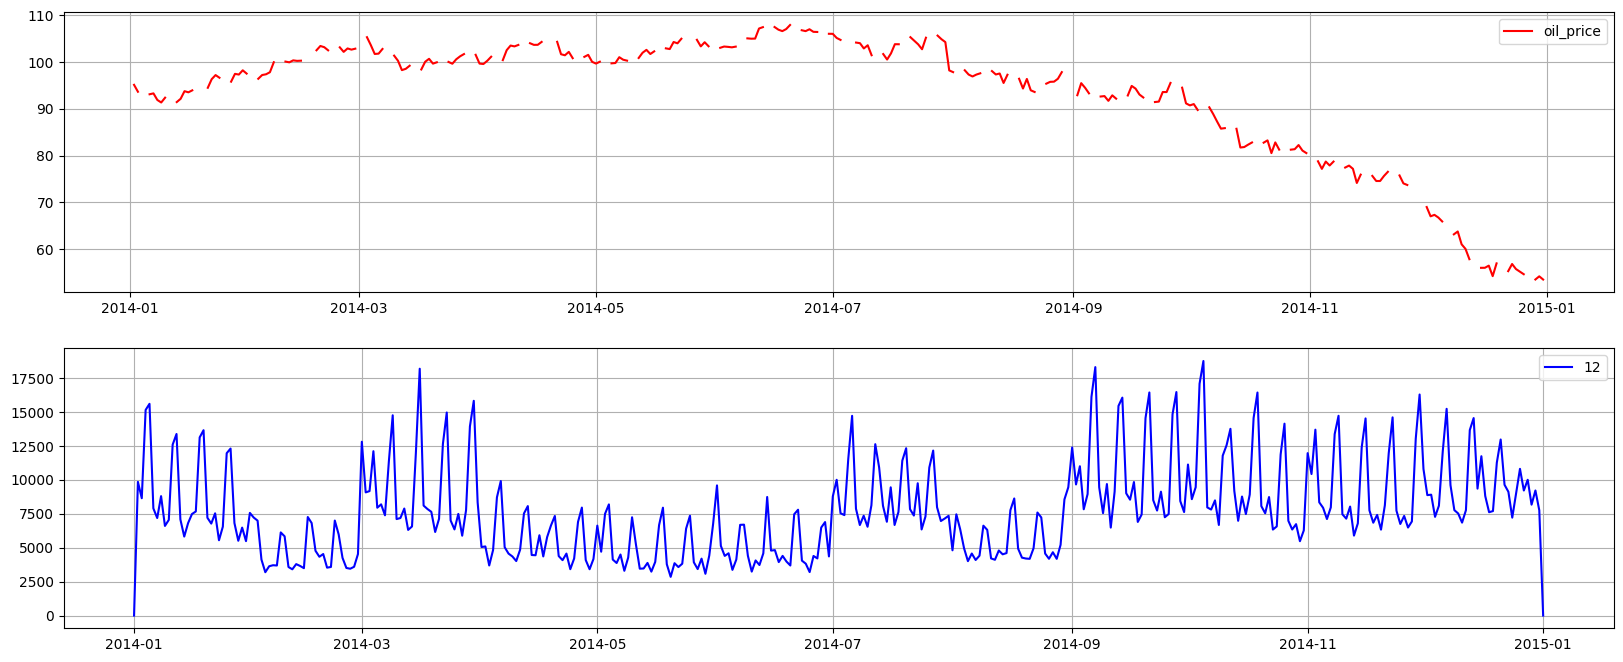

In [ ]:
# 휘발류 가격과 상품 판매량 그래프(1년)
plt.figure(figsize = (20,8))
plt.subplot(2, 1, 1)
plt.plot('Date', 'WTI_Price', data = df3[:365], label='oil_price', color='r')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot('Date', 'Qty', data = df3[:365], label='12', color='b')
plt.grid()
plt.legend()
plt.show()

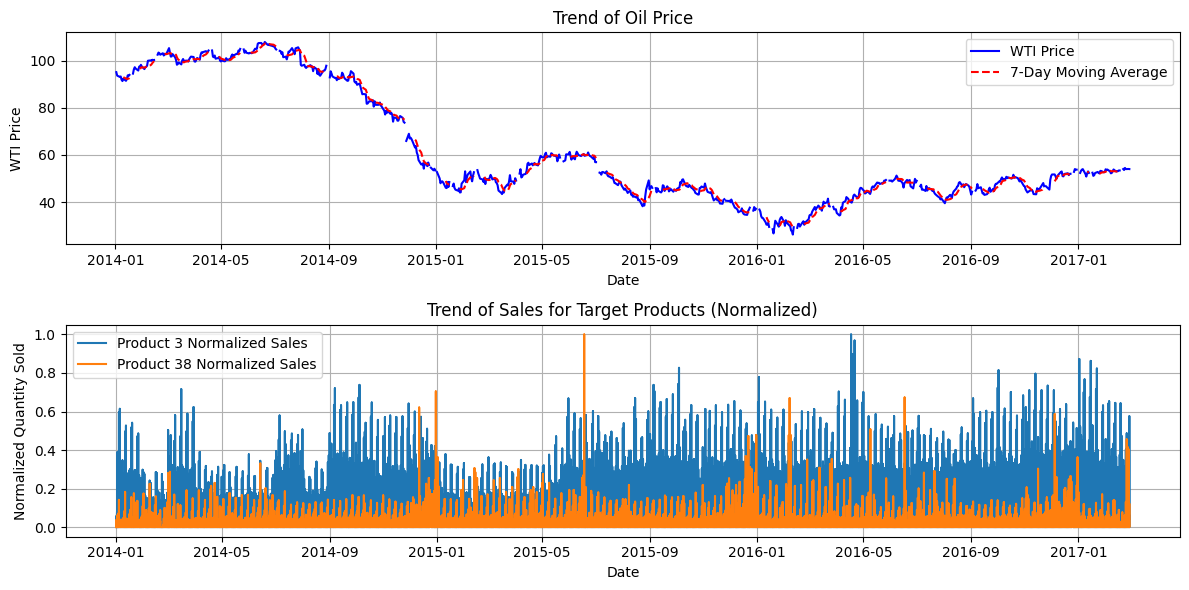

In [ ]:
plt.figure(figsize=(12, 6))

# 휘발유 가격 그래프
plt.subplot(2, 1, 1)
plt.plot(oil_price['Date'], oil_price['WTI_Price'], color='blue', label='WTI Price')
# 7일 이동평균 계산
oil_price['7DayMovingAvg'] = oil_price['WTI_Price'].rolling(window=7).mean()
plt.plot(oil_price['Date'], oil_price['7DayMovingAvg'], color='red', linestyle='--', label='7-Day Moving Average')
plt.title('Trend of Oil Price')
plt.xlabel('Date')
plt.ylabel('WTI Price')
plt.legend()
plt.grid(True)

# 상품 판매량 추이 그래프
plt.subplot(2, 1, 2)
for product_code in target_products:
    product_sales = sales[sales['Product_ID'] == product_code]
    # Min-Max 정규화 적용
    min_val = product_sales['Qty'].min()
    max_val = product_sales['Qty'].max()
    product_sales['Normalized'] = (product_sales['Qty'] - min_val) / (max_val - min_val)
    plt.plot(product_sales['Date'], product_sales['Normalized'], label=f'Product {product_code} Normalized Sales')

plt.title('Trend of Sales for Target Products (Normalized)')
plt.xlabel('Date')
plt.ylabel('Normalized Quantity Sold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 4) 방문 고객수와 상품 판매량 추이 비교

In [ ]:
df4 = pd.merge(sales, orders)
df4 = df4[(df4['Store_ID'] == 44) & (df4['Product_ID'] == 3)]
df4.head()

,Date,Store_ID,Qty,Product_ID,DayOfWeek,Year,Month,Season,CustomerCount,Weekday
585,2014-01-02,44,9853.0,3,3,2014,1,1,4422,3
1291,2014-01-03,44,8647.0,3,4,2014,1,1,4167,4
1997,2014-01-04,44,15153.0,3,5,2014,1,1,5341,5
2703,2014-01-05,44,15606.0,3,6,2014,1,1,5123,6
3409,2014-01-06,44,7900.0,3,0,2014,1,1,3917,0


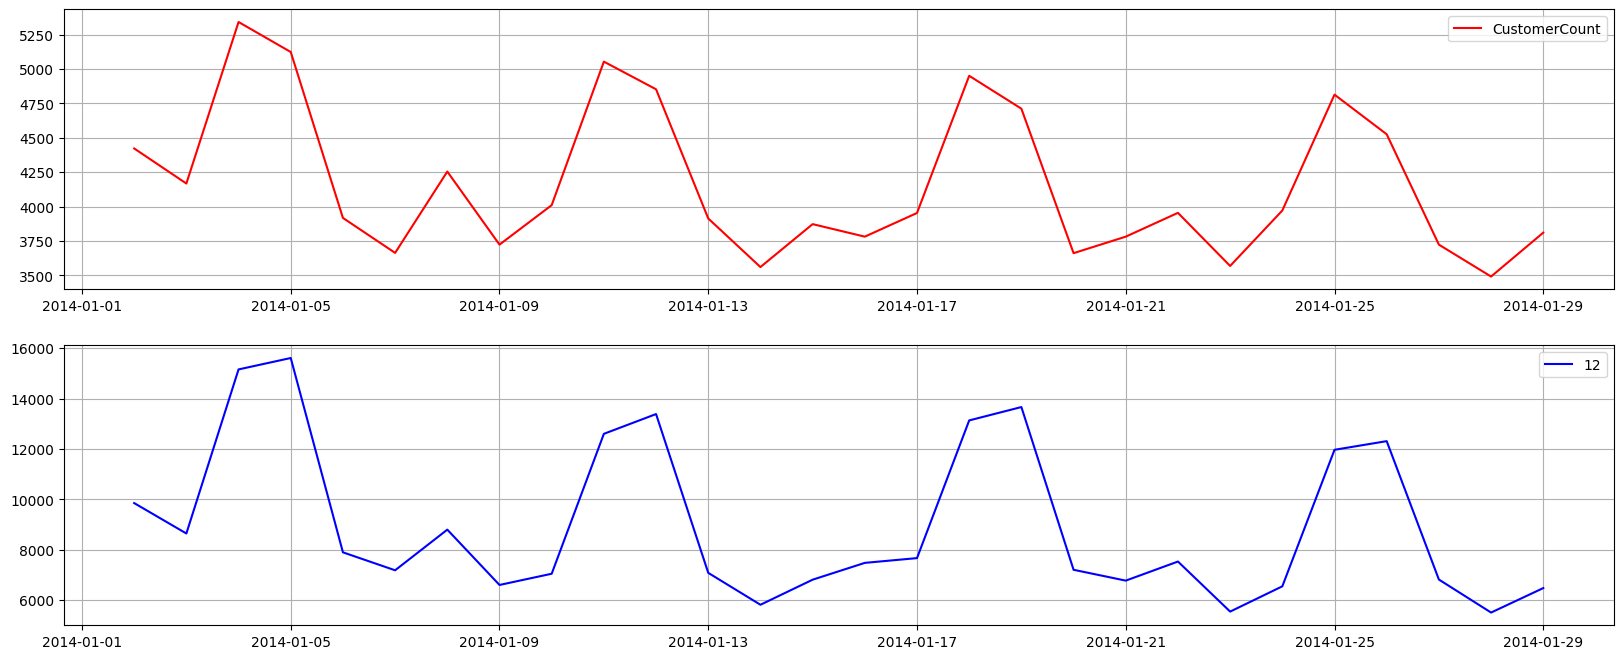

In [ ]:
# 방문 고객수과 상품 판매량 그래프(4주)
plt.figure(figsize = (20,8))
plt.subplot(2, 1, 1)
plt.plot('Date', 'CustomerCount', data = df4[:28], label='CustomerCount', color='r')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot('Date', 'Qty', data = df4[:28], label='12', color='b')
plt.grid()
plt.legend()
plt.show()

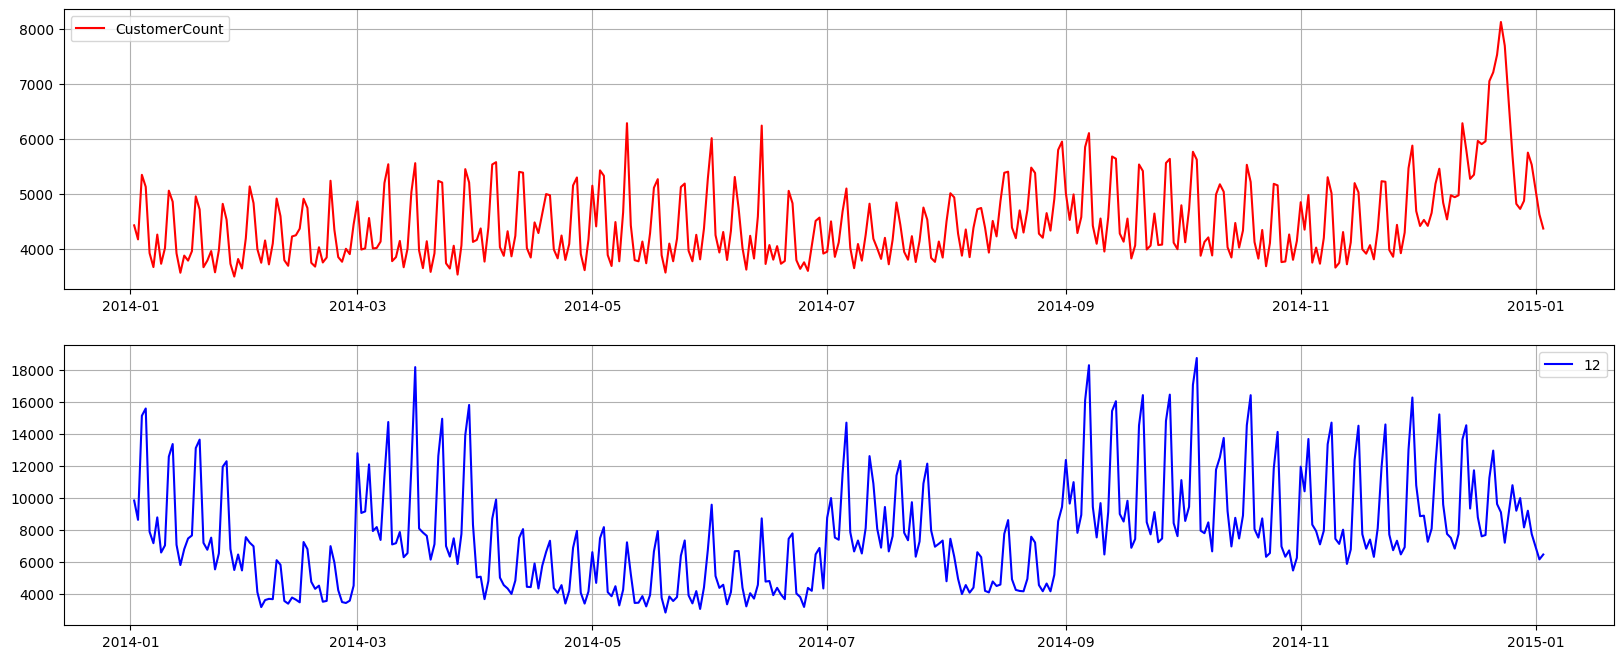

In [ ]:
# 방문 고객수과 상품 판매량 그래프(1년)
plt.figure(figsize = (20,8))
plt.subplot(2, 1, 1)
plt.plot('Date', 'CustomerCount', data = df4[:365], label='CustomerCount', color='r')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot('Date', 'Qty', data = df4[:365], label='12', color='b')
plt.grid()
plt.legend()
plt.show()

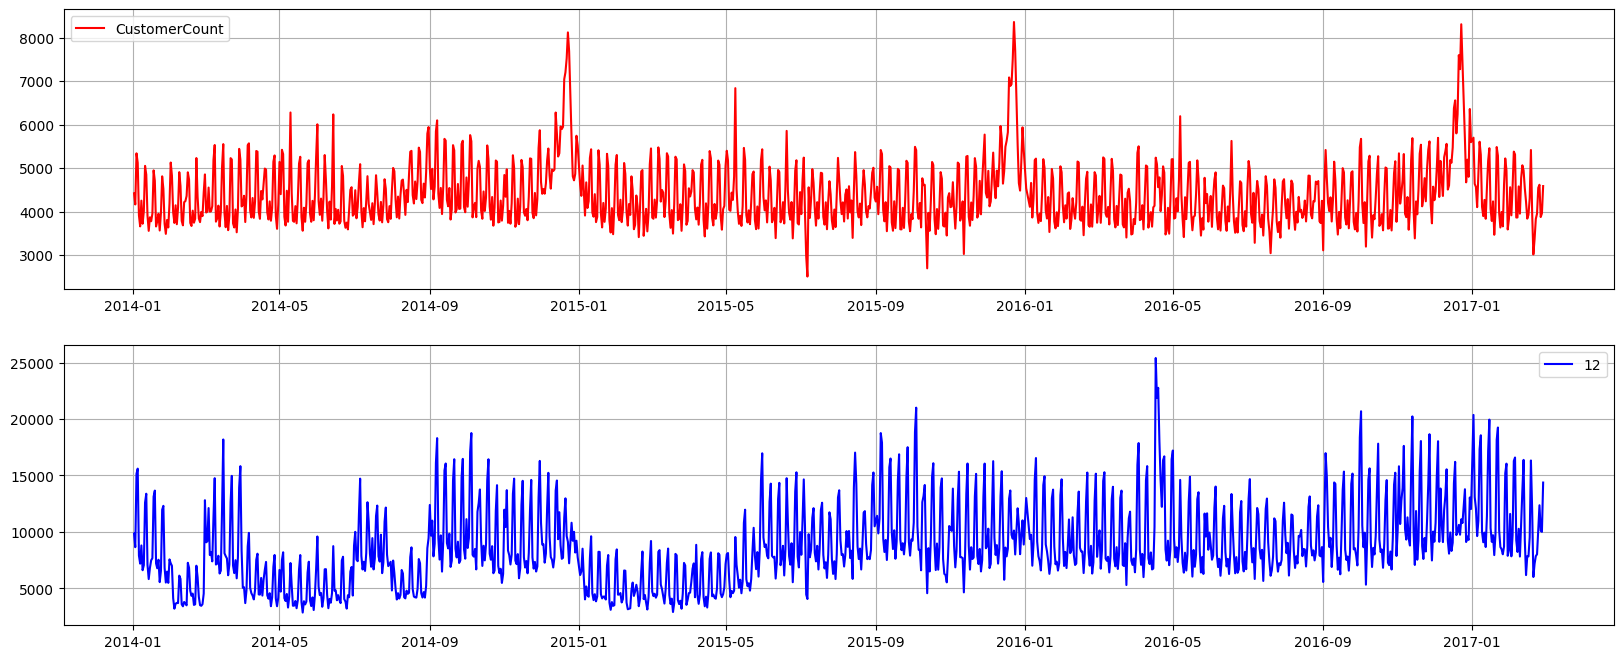

In [ ]:
# 방문 고객수과 상품 판매량 그래프(전체 기간)
plt.figure(figsize = (20,8))
plt.subplot(2, 1, 1)
plt.plot('Date', 'CustomerCount', data = df4, label='CustomerCount', color='r')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot('Date', 'Qty', data = df4, label='12', color='b')
plt.grid()
plt.legend()
plt.show()

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
df.head()

,Date,Store_ID,Qty,Product_ID,DayOfWeek,Year,Month,Season
645,2014-01-01,44,0.0,3,2,2014,1,1
1456,2014-01-02,44,9853.0,3,3,2014,1,1
2267,2014-01-03,44,8647.0,3,4,2014,1,1
3078,2014-01-04,44,15153.0,3,5,2014,1,1
3889,2014-01-05,44,15606.0,3,6,2014,1,1


In [ ]:
# 연도
df['Year'] = df['Date'].dt.year
# 월
df['Month'] = df['Date'].dt.month
# 일
df['Day'] = df['Date'].dt.day
# 요일(월요일:0, 일요일:6)
df['Weekday'] = df['Date'].dt.weekday

df.head()

,Date,Store_ID,Qty,Product_ID,DayOfWeek,Year,Month,Season,Day,Weekday
645,2014-01-01,44,0.0,3,2,2014,1,1,1,2
1456,2014-01-02,44,9853.0,3,3,2014,1,1,2,3
2267,2014-01-03,44,8647.0,3,4,2014,1,1,3,4
3078,2014-01-04,44,15153.0,3,5,2014,1,1,4,5
3889,2014-01-05,44,15606.0,3,6,2014,1,1,5,6


### 2) 요일별 변화량 비교

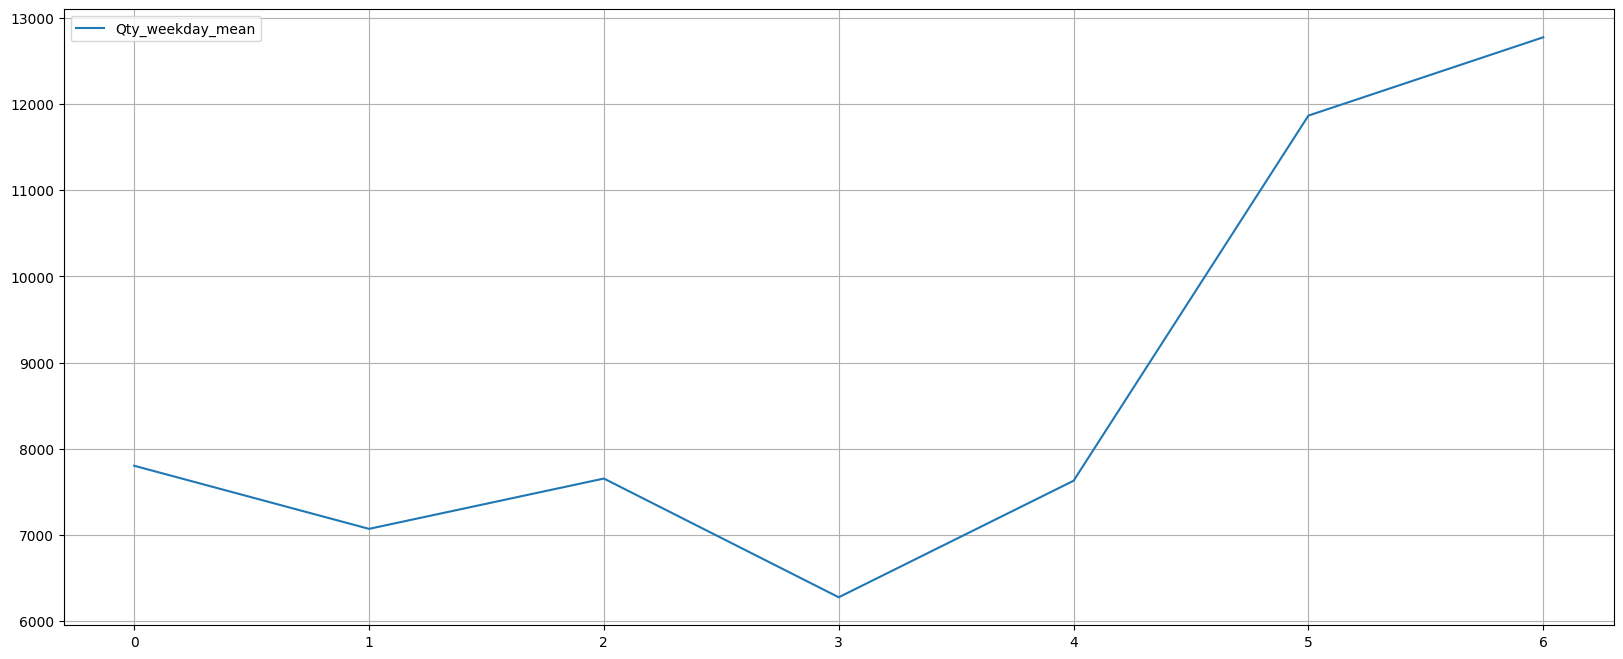

In [ ]:
# 요일별 판매량 평균
df_weekday = df.groupby('Weekday', as_index=False)['Qty'].mean()

# 12번 상품 판매량 요일별 추이(전체 기간)
plt.figure(figsize = (20,8))
plt.plot('Weekday', 'Qty', data = df_weekday, label='Qty_weekday_mean')
plt.grid()
plt.legend()
plt.show()

### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

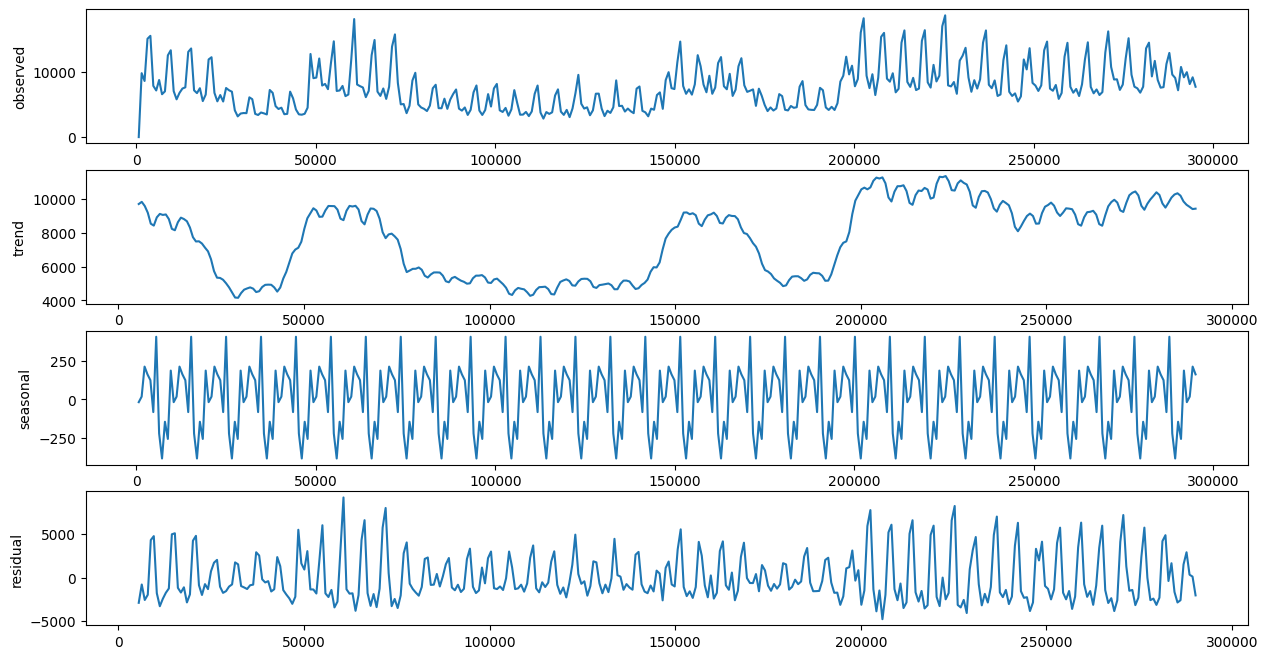

In [ ]:
Product_ID = 3
sdate = '2014-01-01'
edate = '2014-12-31'
period = 12


decomp_result = decomp_plot(Product_ID, sdate, edate, period)

### 4) 그 외 패턴 찾아보기

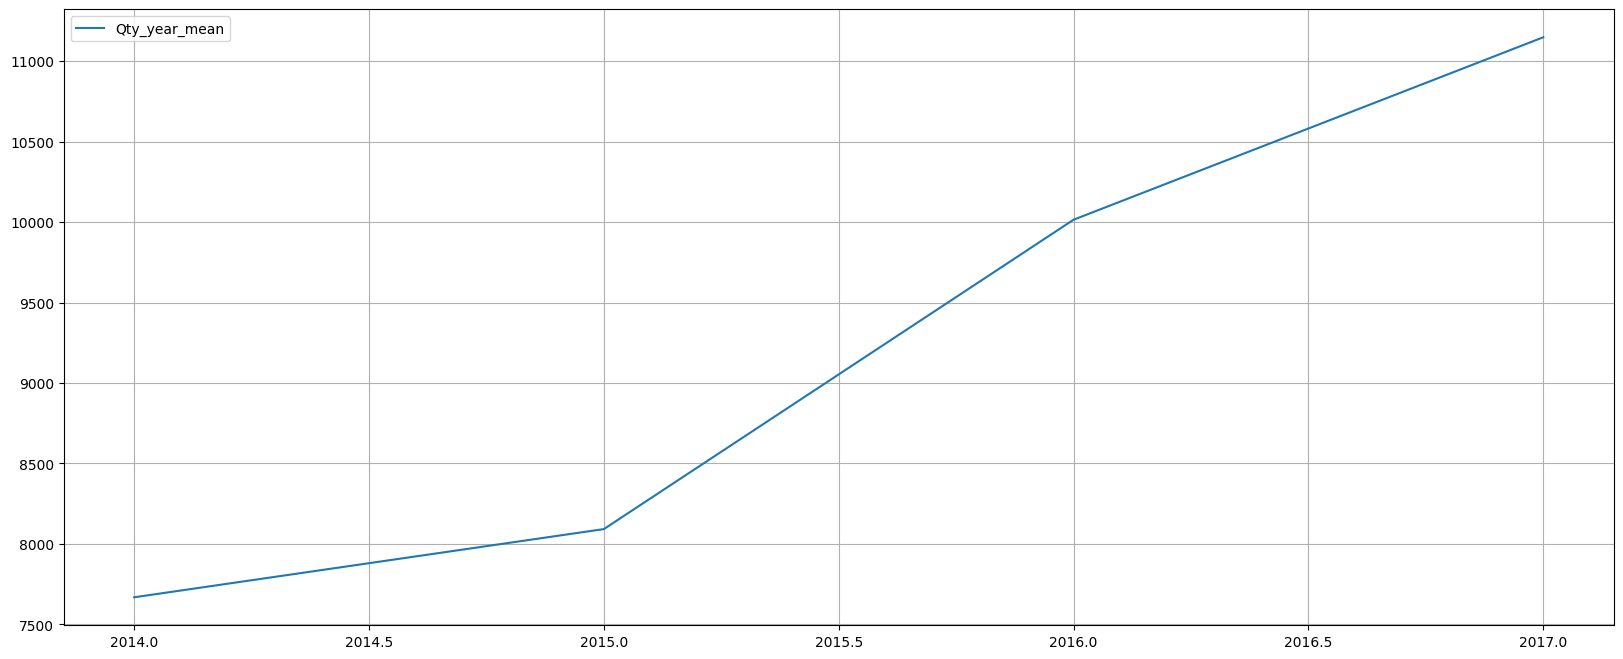

In [ ]:
# 연도별 평균 판매량
df_year = df.groupby('Year', as_index=False)['Qty'].mean()

# 12번 상품 판매량 연도별 추이(전체 기간)
plt.figure(figsize = (20,8))
plt.plot('Year', 'Qty', data = df_year, label='Qty_year_mean')
plt.grid()
plt.legend()
plt.show()

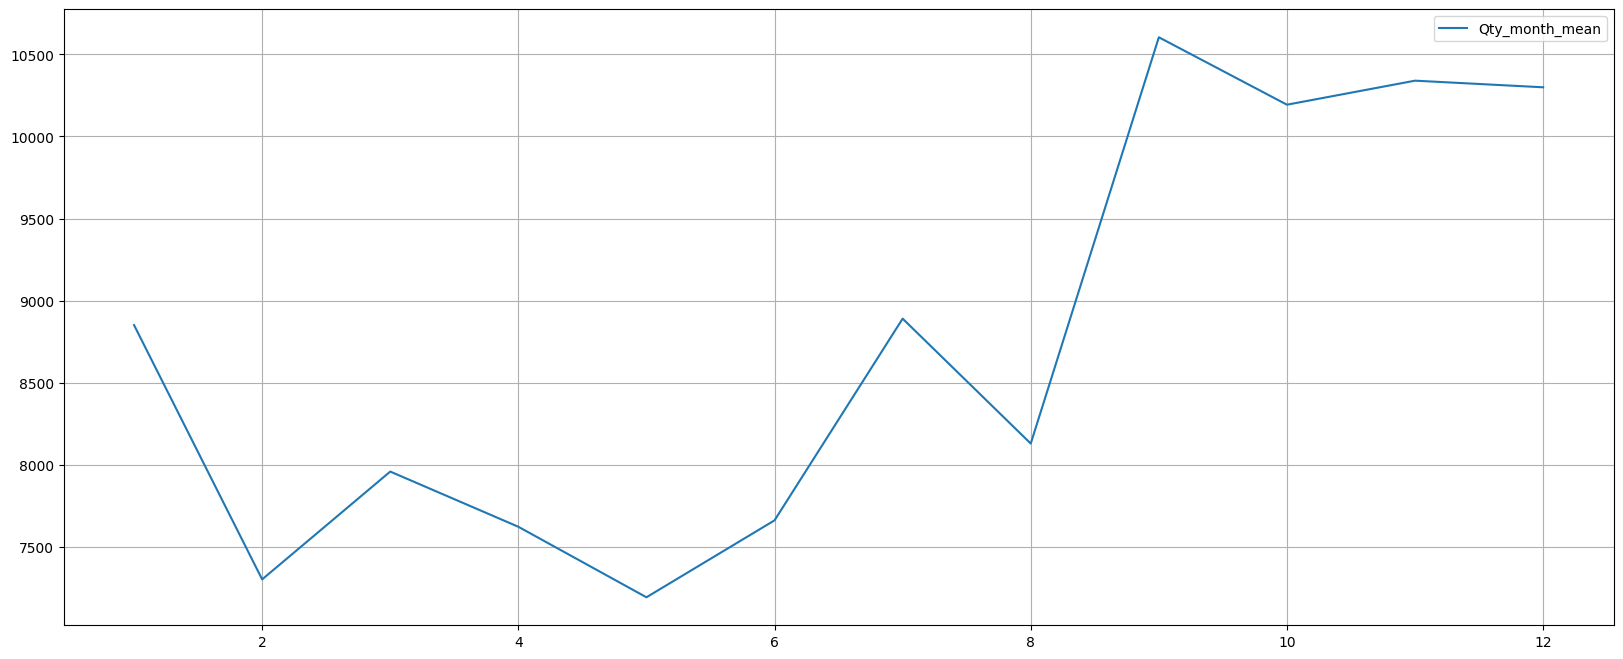

In [ ]:
# 월별 평균 판매량
df_month = df.groupby('Month', as_index=False)['Qty'].mean()

# 12번 상품 판매량 연도별 추이(전체 기간)
plt.figure(figsize = (20,8))
plt.plot('Month', 'Qty', data = df_month, label='Qty_month_mean')
plt.grid()
plt.legend()
plt.show()

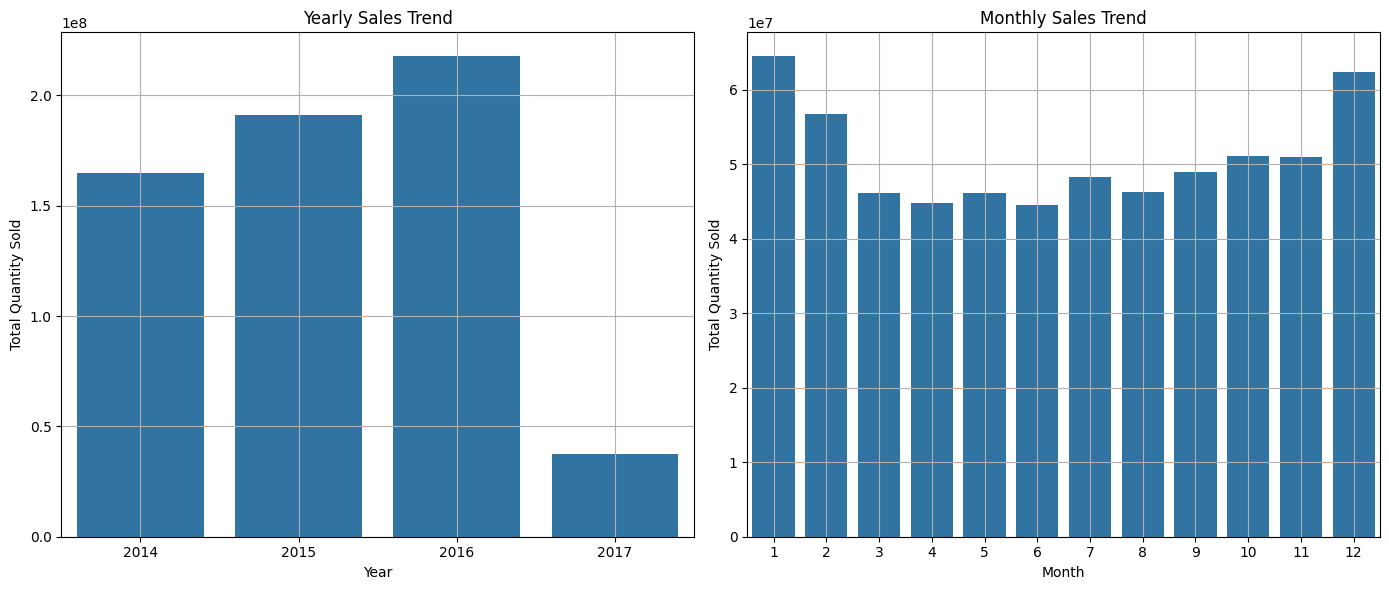

In [ ]:
# 연도별 판매량 분석
sales['Year'] = sales['Date'].dt.year
yearly_sales = sales.groupby('Year')['Qty'].sum()

# 월별 판매량 분석
sales['Month'] = sales['Date'].dt.month
monthly_sales = sales.groupby('Month')['Qty'].sum()

# 연도별, 월별 판매량 변화 추이 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=yearly_sales.index, y=yearly_sales.values)
plt.title('Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Quantity Sold')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.barplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.grid(True)

plt.tight_layout()
plt.show()


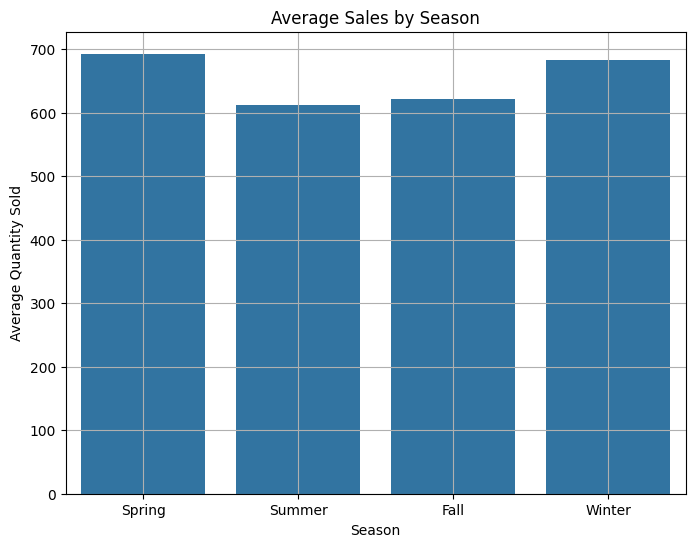

In [ ]:
# 계절 정보 추가
sales['Season'] = (sales['Date'].dt.month % 12 + 3) // 3

# 계절별 판매량 계산
seasonal_sales = sales.groupby('Season')['Qty'].mean()

# 계절별 판매량 분포 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=seasonal_sales.index, y=seasonal_sales.values)
plt.title('Average Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Quantity Sold')
plt.xticks(range(0, 4), ['Spring', 'Summer', 'Fall', 'Winter'])
plt.grid(True)
plt.show()

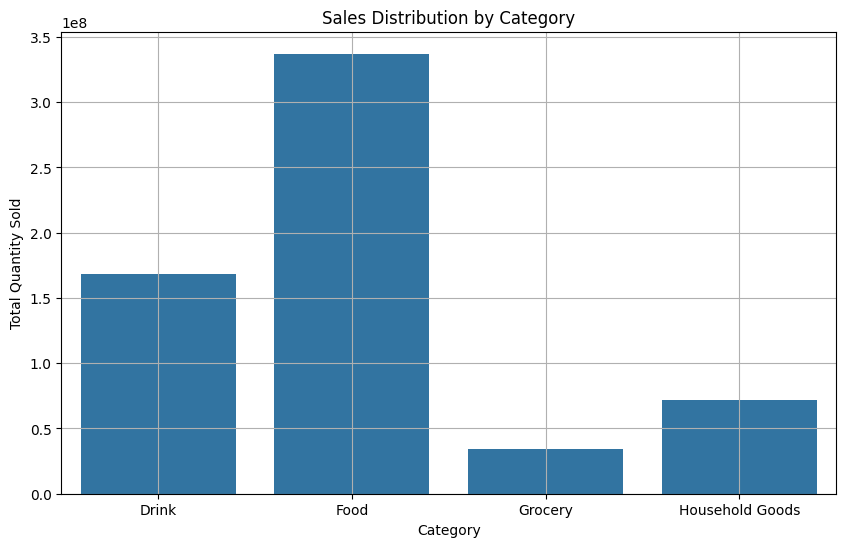

In [ ]:
# 상품 카테고리 정보 추가
merged_data = pd.merge(sales, products, on='Product_ID')

# 상품 카테고리별 판매량 계산
category_sales = merged_data.groupby('Category')['Qty'].sum()

# 상품 카테고리별 판매량 분포 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=category_sales.index, y=category_sales.values)
plt.title('Sales Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()


# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

- 3번 제품
  - 1주일 단위로 주말에 판매량이 많아지는 패턴이 존재
    - 월 ~ 목은 감소하고, 금 ~ 일은 증가
  - 고객 방문수는 연말에 증가하는 패턴이 있다
    - 연말의 이 제품의 판매량도 평균적으로 증가한다
  - 전체 기간으로 볼때 이 제품의 평균 판매량은 증가한다
  - 연초의 판매량이 0이다